# Cultivating Crop Yields: Unraveling Factors and Forecasting using Machine Learning
### 42578 Advanced Business Analytics 
 Xindi Wu s225521
________


Improvements in crop yields have been essential to feed a growing population, fight against climate change, and reduce the amount of land we use for agriculture. Even though there have been great improvement in yields per hectare observed in the past years, it would be misleading to presume the trend will sustain under the global climate change background, where current climate instability and the prevalence of extreme weather events such as droughts and floods could disrupt crop production globally, and rising temperatures and erratic precipitation patterns could impact agriculture. 

Therefore, predicting crop yields and implementing interventions has emerged as a pressing environmental concern today. It is generally presumed that the agricultural yield heavily depends on weather conditions such as rain, temperature, etc. and agricultural measures such as pesticide application.In this project, I will gather and use data on temperature, precipitation, and pesticide usage as features to estimate crop yield across various regions and years. I will employ and compare different machine learning models, which are suitable for predicting continuous outcome variables. Then I will select the best-performing model using R square metrics, make final training and predicting, assess the significance of all features. Based on their importance, I will provide recommendations for enhancing crop production in the context of global climate change.    

The data I utilized is from the [Food and Agriculture Organization (FAO)](https://www.fao.org/home/en) and the [World Bank](https://www.worldbank.org/en/home), encompassing yield data for ten types of crops, as well as average annual temperature, average annual precipitation, and pesticide usage, saved in separate csv files with designated area and year. 

## Prepocessing crop yield data

In [1]:
# import modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [2]:
# import data downloaded from FAO 
df_yield = pd.read_csv('yield.csv')
df_yield.shape

(56717, 12)

In [3]:
df_yield.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [4]:
# drop unwanted columns, just keeping area(country), item, year and yield value
df_yield = df_yield.drop(['Year Code','Element Code','Element','Year Code','Area Code','Domain Code','Domain','Unit','Item Code'], axis=1)
df_yield.head()

,Area,Item,Year,Value
0,Afghanistan,Maize,1961,14000
1,Afghanistan,Maize,1962,14000
2,Afghanistan,Maize,1963,14260
3,Afghanistan,Maize,1964,14257
4,Afghanistan,Maize,1965,14400


In [5]:
# inspect missing values
df_yield.isna().sum()

Area     0
Item     0
Year     0
Value    0
dtype: int64

In [6]:
# convert long format to wide format and set multilevel indices
wide_yield = df_yield.pivot(index=['Area','Item'], columns='Year', values='Value')
wide_yield.head()

Year                        1961     1962     1963     1964     1965     1966  \
Area        Item                                                                
Afghanistan Maize        14000.0  14000.0  14260.0  14257.0  14400.0  14400.0   
            Potatoes     86667.0  76667.0  81333.0  86000.0  88000.0  90667.0   
            Rice, paddy  15190.0  15190.0  15190.0  17273.0  17273.0  15180.0   
            Wheat        10220.0   9735.0   8317.0   9510.0   9723.0   8666.0   
Albania     Maize         9541.0   9079.0  11924.0  11634.0  10509.0  15051.0   

Year                        1967      1968      1969     1970  ...      2007  \
Area        Item                                               ...             
Afghanistan Maize        14144.0   17064.0   17177.0  14757.0  ...   26277.0   
            Potatoes     98000.0  100000.0  101987.0  95364.0  ...  150400.0   
            Rice, paddy  19223.0   19515.0   19757.0  18119.0  ...   32471.0   
            Wheat        11232.0   11562.0   11855.0   9563.0  ...   18183.0   
Albania     Maize        17241.0   18782.0   19485.0  20718.0  ...   46732.0   

Year                         2008      2009      2010      2011      2012  \
Area        Item                                                            
Afghanistan Maize         26277.0   21429.0   16448.0   16400.0   21986.0   
            Potatoes     140000.0  140000.0  120000.0  100000.0  109524.0   
            Rice, paddy   32211.0   32250.0   32308.0   32000.0   24390.0   
            Wheat         12263.0   19666.0   19252.0   15179.0   20104.0   
Albania     Maize         50000.0   55693.0   66790.0   59869.0   67290.0   

Year                         2013      2014      2015      2016  
Area        Item                                                 
Afghanistan Maize         21972.0   24882.0   21457.0   20517.0  
            Potatoes     131960.0  136054.0  130903.0  119868.0  
            Rice, paddy   24980.0   24409.0   25000.0   29963.0  
            Wheat         20248.0   20237.0   21959.0   19803.0  
Albania     Maize         69533.0   69091.0   69597.0   64877.0  

[5 rows x 56 columns]

In [7]:
# calculate world average yields of a certain item
# save each year's df to a dictionary
dfs = {}
for i in range(1961,2017,1):
    
    series = wide_yield.groupby(level=['Item'])[i].mean().round(1)
    df = pd.DataFrame(series)
    df_name = f'df_{i}'  
    dfs[df_name] = df

In [8]:
# concatenate dfs from the dictionary to form a complete crop yields df 
# set year as index, crop as columns
yield_df = pd.DataFrame(index=df.index)
for i in dfs:
    yield_df = pd.concat([yield_df, dfs[i]], axis=1)
yield_df = yield_df/10000 # convert scale into ton
yield_df = yield_df.T

## Plotting crop yield trend and yearly increase

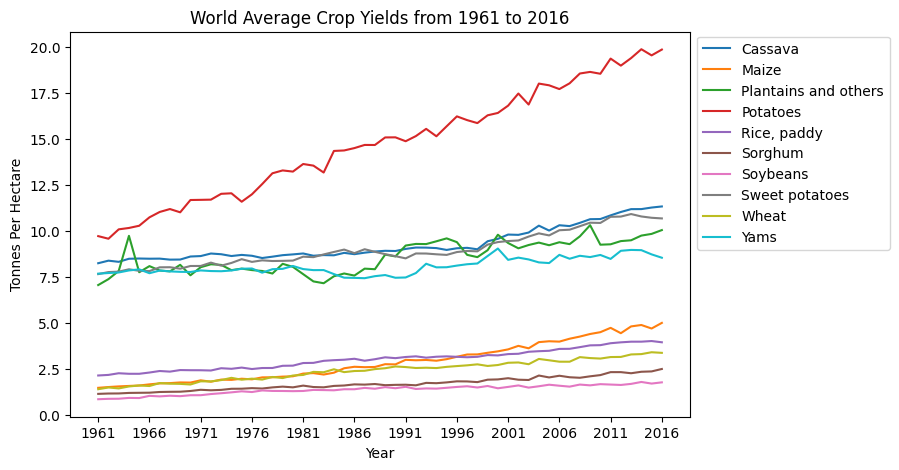

In [9]:
# plot world average crop yields
fig, ax = plt.subplots(figsize=(8, 5))
ax = yield_df.plot(kind='line', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.71))
ax.set_xticks(range(1961, 2017, 5))
ax.set_title('World Average Crop Yields from 1961 to 2016')
ax.set_xlabel('Year')  
ax.set_ylabel('Tonnes Per Hectare')
plt.show()

In [10]:
# calculate crop yields increase from last year
yield_diff_df = pd.DataFrame(index=yield_df.index)
for column in yield_df.columns[:]:
    diff_column = f'{column}'  
    yield_diff_df[diff_column] = yield_df[column].diff().round(3)

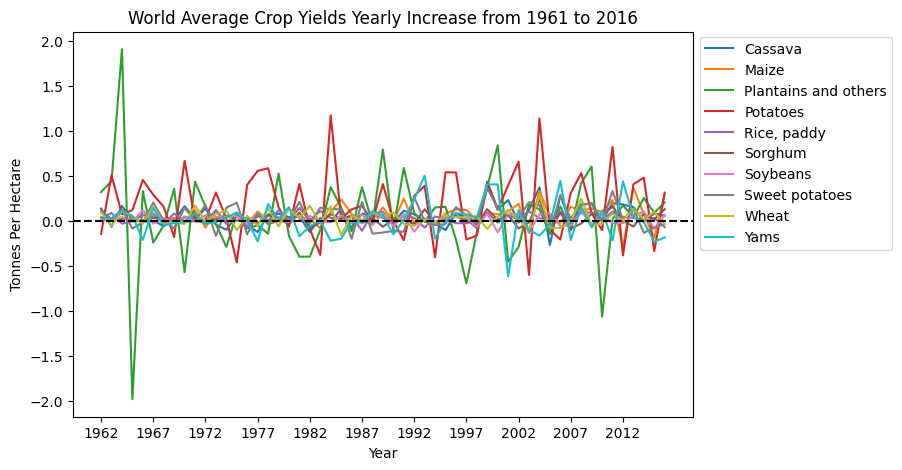

In [11]:
# plot world average crop yields yearly increase
fig, ax = plt.subplots(figsize=(8, 5))
ax = yield_diff_df.plot(kind='line', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.71))
ax.set_xticks(range(1962, 2017, 5))
ax.axhline(y=0, color='black', linestyle='dashed')
ax.set_title('World Average Crop Yields Yearly Increase from 1961 to 2016')
ax.set_xlabel('Year')  
ax.set_ylabel('Tonnes Per Hectare')
plt.show()

From the above two graphs, we can see that the crop yields for all items from 1961 to 2016 have shown an increasing trend. Among these crops, potatoes have exhibited the highest growth rate, with the average yield per hectare rising from 10 to 20 tonnes. The average yields for yam, cassava, sweet potatoes, plantains, and others have ranged roughly between 7.5 and 10 tonnes per hectare, with slight incremental improvements observed over the years.      

In contrast, the average yields for maize, rice, paddy, wheat, sorghum, and soybeans have remained relatively low, all averaging below 5 tonnes per hectare.        

Analyzing the yearly changes, most years have experienced a net increase in crop yields, with notable variations observed. Among all crops, potatoes and plantains, along with others, have displayed more significant fluctuations. In a broader perspective, the magnitude of fluctuations from 1961 to 2016 has slightly increased, indicating a gradual rise in climate instability.

## Prepocessing rainfall, pesticide and temperature data

The precipitation and temperature data was gathered from [Climate Change World Portal](https://climateknowledgeportal.worldbank.org/download-data) of the World Bank, while the pesticide data was downloaded from [FAOSTAT](https://www.fao.org/faostat/en/#data/RP) of the FAO.    

The unit for precipitation is mm, for temperature is Celsius degree, and for pesticide usage is tonnes. All of them are varied in country and year, making data more accurate. 

In [12]:
# rainfall
df_rain = pd.read_csv('rainfall.csv')
df_rain.head()

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [13]:
# process df
df_rain = df_rain.rename(index=str, columns={" Area": 'Area'})
df_rain['average_rain_fall_mm_per_year'] = pd.to_numeric(df_rain['average_rain_fall_mm_per_year'],errors = 'coerce')
df_rain = df_rain.dropna()

In [14]:
# merge yield dataframe with rain dataframe by year and area columns 
yield_df = pd.merge(df_yield, df_rain, on=['Year','Area'])

In [15]:
# pesticide
df_pes = pd.read_csv('pesticides.csv')
df_pes.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [16]:
# renmame column and drop unwanted columns
df_pes = df_pes.rename(index=str, columns={"Value": "pesticides_tonnes"})
df_pes = df_pes.drop(['Element','Domain','Unit','Item'], axis=1)

In [17]:
# merge pesticides df with yield df 
yield_df = pd.merge(yield_df, df_pes, on=['Year','Area'])

In [18]:
# temperature
avg_temp=  pd.read_csv('temp.csv')
avg_temp = avg_temp.rename(index=str, columns={"year": "Year", "country":'Area'})

In [19]:
# merge temperature dataframe with yield dataframe 
yield_df = pd.merge(yield_df,avg_temp, on=['Area','Year'])
yield_df.head()

,Area,Item,Year,Value,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [20]:
# inspect missing values of the complete dataset
yield_df.isnull().sum()

Area                             0
Item                             0
Year                             0
Value                            0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [21]:
# find the ten largest yield production area
yield_df.groupby(['Area'],sort=True)['Value'].sum().nlargest(3)

Area
India     327420324
Brazil    167550306
Mexico    130788528
Name: Value, dtype: int64

In this dataset, the top three countries with the largest crop yield are India, Brazil and Mexico.

In [22]:
# find the top 10 yield's combination of item and area 
yield_df.groupby(['Item','Area'],sort=True)['Value'].sum().nlargest(10)

Item            Area          
Cassava         India             142810624
Potatoes        India              92122514
                Brazil             49602168
                United Kingdom     46705145
                Australia          45670386
Sweet potatoes  India              44439538
Potatoes        Japan              42918726
                Mexico             42053880
Sweet potatoes  Mexico             35808592
                Australia          35550294
Name: Value, dtype: int64

India is the highest for production of cassava and potatoes. Potatoes are the dominated crop in terms of yield quantity in the dataset, which could also be told from that six out of the top ten crop yields are potatoes from six countries. 

## Explore correlation between factors

C:\Users\wuxin\AppData\Local\Temp\ipykernel_17248\1010840967.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation_data, dtype=np.bool)


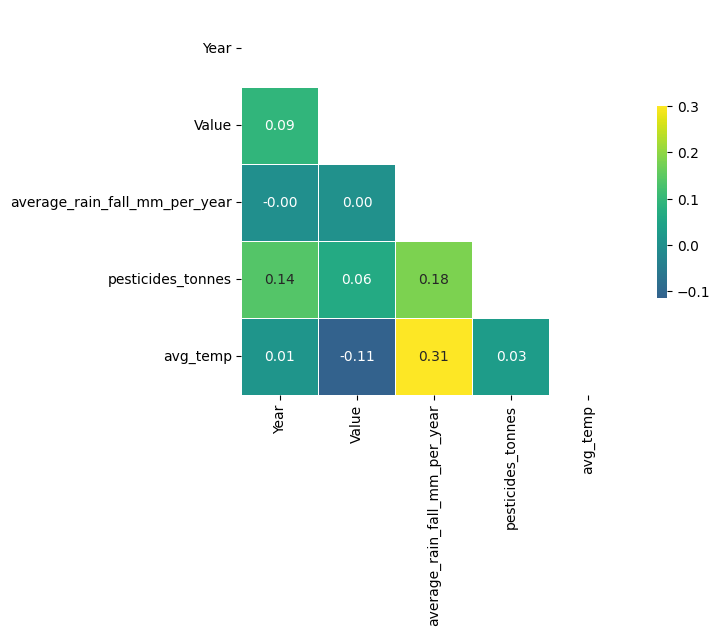

In [23]:
# check correlations among different columns by visualizing the correlation matrix as a heatmap
correlation_data=yield_df.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.palette="vlag"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, annot=True, fmt='.2f', cmap='viridis',mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Because all correlations are about or lower than 0.3, which is usually seen as slightly correlated or no correlation, they are proper to use as separate features in the machine learning models.

## Crop yield prediction through machine learning

### Data Cleaning

In [25]:
# encode categorical variables
# get features for machine learning
yield_df_onehot = pd.get_dummies(yield_df, columns=['Area',"Item"], prefix = ['Country',"Item"])
features = yield_df_onehot.loc[:, yield_df_onehot.columns != 'Value']
label = yield_df['Value']

# exclude year in features
features = features.drop(['Year'], axis=1)

# scale features
scaler=MinMaxScaler()
features=scaler.fit_transform(features) 

# split features and label dfs into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.3, random_state=42)

### Evaluate performance using cross validation on all six(seven) models

In [26]:
# Define a list of machine learning models that are suitable for continous y value
models = [
    ("GradientBoosting", GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0)),
    ("RandomForest", RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0)),
    ("SVR", svm.SVR()),
    ("DecisionTree", DecisionTreeRegressor()),
    ("Ridge", Ridge()),
    ("BayesianRidge", BayesianRidge())
]

# Compare models through pipeline to raise efficiency  
# split traning set into 5 folds and do separate evaluation, make the most use of training data for validation
results = []
for name, model in models:
    pipeline = Pipeline([("model", model)])
    scores = cross_val_score(pipeline, train_data, train_labels, cv=5, scoring='r2')
    avg_score = scores.mean()
    results.append((name, avg_score))

# Print out and compare performance using r square metrics
for name, score in results:
    print(f"{name}: {score:.3f}")

GradientBoosting: 0.894
RandomForest: 0.678
SVR: -0.198
DecisionTree: 0.955
Ridge: 0.743
BayesianRidge: 0.743


In [27]:
# an alternative method: neural network
# could reach high accuracy/ low loss, but unable to detect intuitively which feature has a larger impact on y 

# Build the neural network model
model = Sequential()
model.add(Dense(32, input_dim=train_data.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model
model.fit(train_data, train_labels, epochs=100, batch_size=32, verbose=0)

# Make predictions
nn_predictions = model.predict(test_data).flatten()

# Calculate R2 score
nn_r2 = r2_score(test_labels, nn_predictions)
print(f"Neural Network R2 Score: {nn_r2:.3f}")

265/265 [==============================] - 1s 4ms/step
Neural Network R2 Score: 0.886


The evaluation metric is R Sqaure (coefficient of determination) , which represents the proportion of the variance the features can explain in y. R Sqaure score shows how well data points fit a line. The bigger, the better.

From results viewd above, Decision Tree Regressor has the highest R Sqaure score of about 96%, which proved to be the best predictor in this case.

In [28]:
# prepare the dataset and calculate item-wise r square score

# Remove 'Year' column from yield_df_onehot
yield_df_onehot = yield_df_onehot.drop(['Year'], axis=1)

#setting test data to columns from dataframe and excluding 'hg/ha_yield' values where ML model should be predicting 

test_df=pd.DataFrame(test_data,columns=yield_df_onehot.loc[:, yield_df_onehot.columns != 'Value'].columns) 

# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe

cntry=test_df[[col for col in test_df.columns if 'Country' in col]].stack()[test_df[[col for col in test_df.columns if 'Country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]
itm=test_df[[col for col in test_df.columns if 'Item' in col]].stack()[test_df[[col for col in test_df.columns if 'Item' in col]].stack()>0]
itmlist=list(pd.DataFrame(itm).index.get_level_values(1))
items=[i.split("_")[1] for i in itmlist]

test_df.drop([col for col in test_df.columns if 'Item' in col],axis=1,inplace=True)
test_df.drop([col for col in test_df.columns if 'Country' in col],axis=1,inplace=True)

# Assign 'Country' and 'Item' information to test_df
test_df['Country']=countries
test_df['Item']=items

# Make predictions using a DecisionTreeRegressor model
clf=DecisionTreeRegressor()
model=clf.fit(train_data,train_labels)

test_df["yield_predicted"]= model.predict(test_data)
test_df["yield_actual"]=pd.DataFrame(test_labels)["Value"].tolist()

# Group the data by 'Item' and calculate R-squared for each group
test_group=test_df.groupby("Item")
test_group.apply(lambda x: r2_score(x.yield_actual,x.yield_predicted))

Item
Cassava                 0.929723
Maize                   0.893886
Plantains and others    0.774576
Potatoes                0.907770
Rice, paddy             0.897542
Sorghum                 0.789064
Soybeans                0.818327
Sweet potatoes          0.830601
Wheat                   0.923145
Yams                    0.928045
dtype: float64

## Make prediction by the best predictor and visualize results

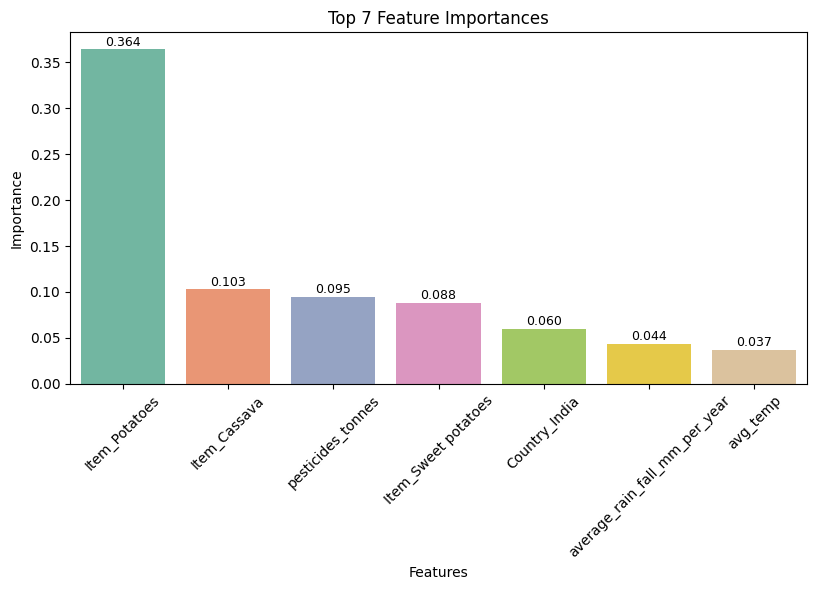

In [29]:
# Calculate feature importances and create a DataFrame
varimp = {'imp': model.feature_importances_, 'names': yield_df_onehot.columns[yield_df_onehot.columns != "Value"]}
df = pd.DataFrame.from_dict(varimp)

# Sort the DataFrame by importance in descending order
df.sort_values(by=["imp"], ascending=False, inplace=True)
df = df.dropna()

# Select the top 7 important factors
df = df.nlargest(7, 'imp')

# Set up the plot
a4_dims = (8.27, 6)  # Adjust the height for better visualization
fig, ax = plt.subplots(figsize=a4_dims)

# Create a vertical bar plot using Seaborn with a different color palette
sns.barplot(x="names", y="imp", palette="Set2", data=df, ax=ax)  # Use "Set2" palette for different colors
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 7 Feature Importances")
plt.tight_layout()

plt.show()

From the graph we can see that the crop being potatoes has the highest importance in the prediction making for the model, which has the highest crop yield per hectare in the dataset. Then comes cassava out of similar reason. The effect of pesticides come third, indicating the importance of pesticide utilization and reduce pest damage. And then if the crop is sweet potatoes, we can predict the crop yield to be high. If the crop is grown in India, then it tend to have higher production since Indis has the largest crops sum in the dataset. Then comes rainfall and temprature. The assumption about those two features were correct, where they both significanally impact the expected crops yield in the model. 